<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Étape 1 : Préparation des Données</h2>
</div>

In [96]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, BoundaryNorm
# Ignorer les warning
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

In [73]:
# Importer le fichier csv
df = pd.read_csv('C:/Users/Belmon Romain/Documents/Epitech/Projet 4/Epitech/Rush 4/Data/Camp_Market.csv', delimiter=';')

In [3]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [75]:
# Concertir les colonnes qui sont en string en int si possible
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        except:
            pass

In [77]:
# Encoder les variables catégorielles
Marital_Status_map = {
    'Single': 0,
    'Married': 1,
    'Together': 2,
    'Divorced': 3,
    'Widow': 4,
    'Alone': 5,
    'Absurd': 6,
    'YOLO': 7
}

Education_map = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
df['Marital_Status_Code'] = df['Marital_Status'].map(Marital_Status_map)
df['Education_Code'] = df['Education'].map(Education_map)

In [79]:
# Créer une colonne 'Tranche d'âge'
bins = [0, 30, 40, 50, 60, 70, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70+']
df['Age_Group'] = pd.cut(2025 - df['Year_Birth'], bins=bins, labels=labels)
df['Age'] = 2022 - df['Year_Birth']
# Nettoyer les données
df_clean = df.dropna(subset=['Education_Code', 'Marital_Status_Code', 'Income']).copy()

In [81]:
# Filtrer les personnes de 90 ans ou moins
df_clean = df_clean[df_clean['Age'] <= 90]
df_clean = df_clean[~df_clean['Marital_Status_Code'].isin([6, 7])]

# Filtrer les données Income vide et les salaires trop élevées (un client avec 666 666.66 €)
df_clean = df_clean[df_clean['Income'] <= 200000]
df_clean = df_clean.dropna(subset=['Income'])
df_clean = df_clean.dropna(how='all')
# Conversion en format date
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], errors='coerce')

In [83]:
# Supprimer les doublons
df_clean = df_clean.drop_duplicates()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Étape 2 : Analyse Exploratoire</h2>
</div>

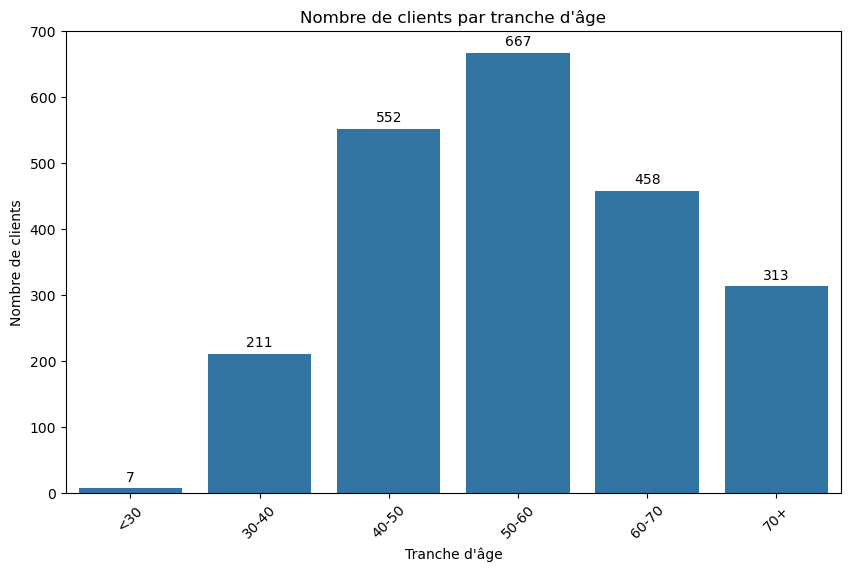

In [17]:
# nombre de clients par tranche d'âge
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df_clean, x='Age_Group')

plt.title("Nombre de clients par tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)

# Ajouter le nombre au-dessus de chaque barre
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Afficher
plt.show()

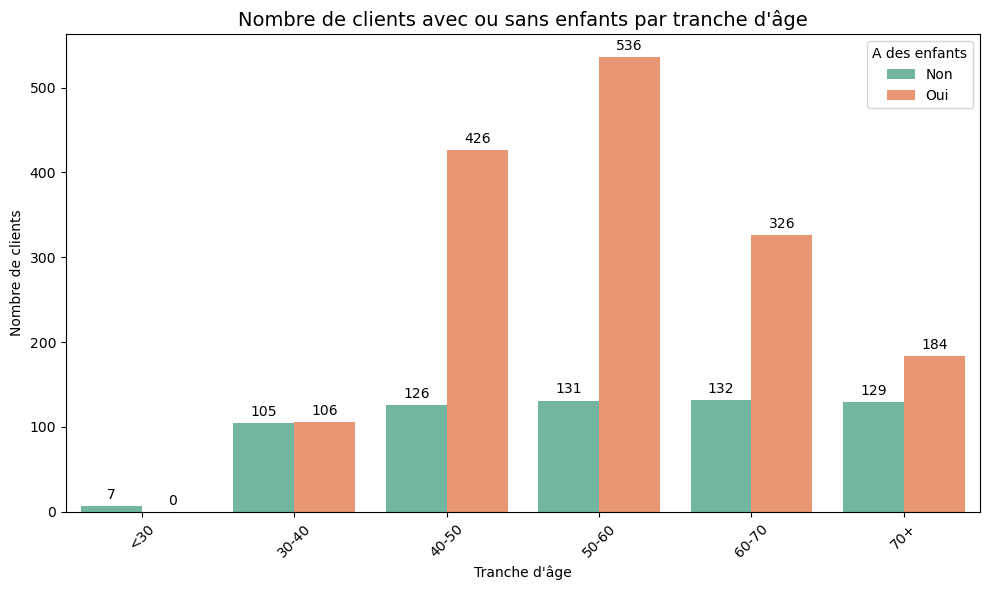

In [19]:
# Connaitre si un clinet a des enfants ou non
df_clean['A_enfant'] = df_clean.apply(lambda x: 'Oui' if (x['Kidhome'] + x['Teenhome']) > 0 else 'Non', axis=1)
nb_enfant_age = df_clean.groupby(['Age_Group', 'A_enfant']).size().reset_index(name='Nb_clients')

# Barplot côte à côte
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=nb_enfant_age,
    x='Age_Group',
    y='Nb_clients',
    hue='A_enfant',
    palette='Set2'
)

# Ajouter les valeurs au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title("Nombre de clients avec ou sans enfants par tranche d'âge", fontsize=14)
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)
plt.legend(title="A des enfants")
plt.tight_layout()

# Afficher
plt.show()

Nombre moyen d'achats par an et par moyen d'achat :
       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
month                                                            
1             4.350515             2.824742           6.139175   
2             3.960452             2.666667           5.892655   
3             3.985646             2.287081           5.521531   
4             3.751381             2.696133           5.519337   
5             3.801887             2.768868           5.660377   
6             3.709877             2.333333           5.283951   
7             3.710000             2.180000           5.750000   
8             4.456621             2.748858           5.990868   
9             4.359788             3.000000           6.026455   
10            4.259615             2.774038           5.879808   
11            4.672131             3.109290           6.530055   
12            3.712644             2.356322           5.356322   

       NumDealsPurchase

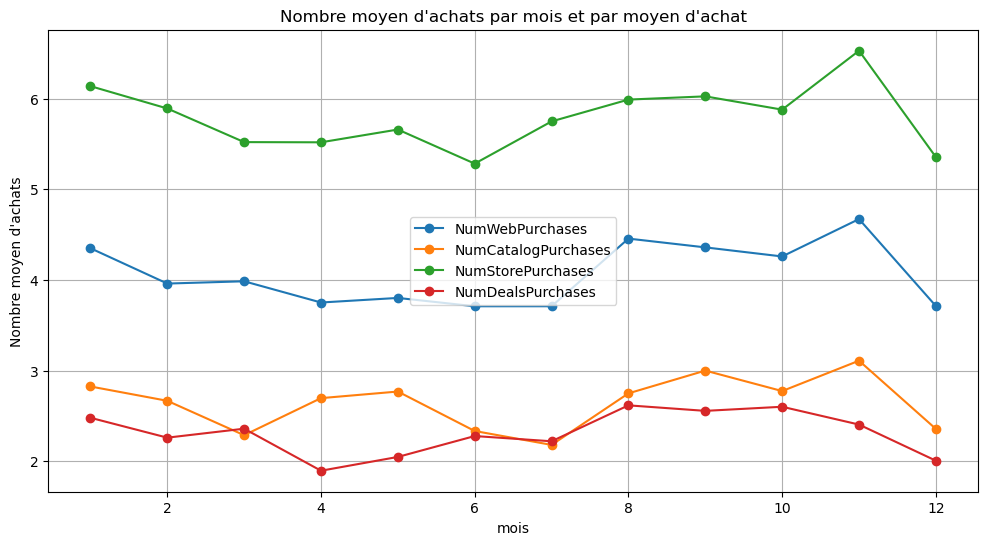

In [41]:
# Extraire le mois
df_clean['month'] = df_clean['Dt_Customer'].dt.month
# Sélectionner les colonnes d'achat
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases']

# Calculer la moyenne des achats par année et par type d'achat
average_purchases_by_year = df_clean.groupby('month')[purchase_columns].mean()

# Afficher le résultat
print("Nombre moyen d'achats par an et par moyen d'achat :")
print(average_purchases_by_year)
# Tracer un graphique
average_purchases_by_year.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Nombre moyen d\'achats par mois et par moyen d\'achat')
plt.xlabel('mois')
plt.ylabel('Nombre moyen d\'achats')
plt.grid(True)
plt.show()

Nombre moyen d'achats par an et par moyen d'achat :
         MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
month                                                            
1      301.644330  33.850515       164.597938        39.608247   
2      308.491525  26.367232       173.180791        44.451977   
3      293.956938  22.066986       146.722488        28.645933   
4      261.403315  24.950276       175.198895        36.950276   
5      291.745283  25.212264       176.297170        39.212264   
6      238.302469  22.697531       139.981481        33.104938   
7      271.900000  20.910000       122.570000        29.030000   
8      339.100457  26.789954       180.328767        38.155251   
9      329.529101  28.343915       193.232804        47.883598   
10     345.269231  24.692308       150.581731        31.798077   
11     380.169399  28.650273       205.786885        43.781421   
12     267.195402  28.666667       152.195402        34.609195   

       MntSweetProducts

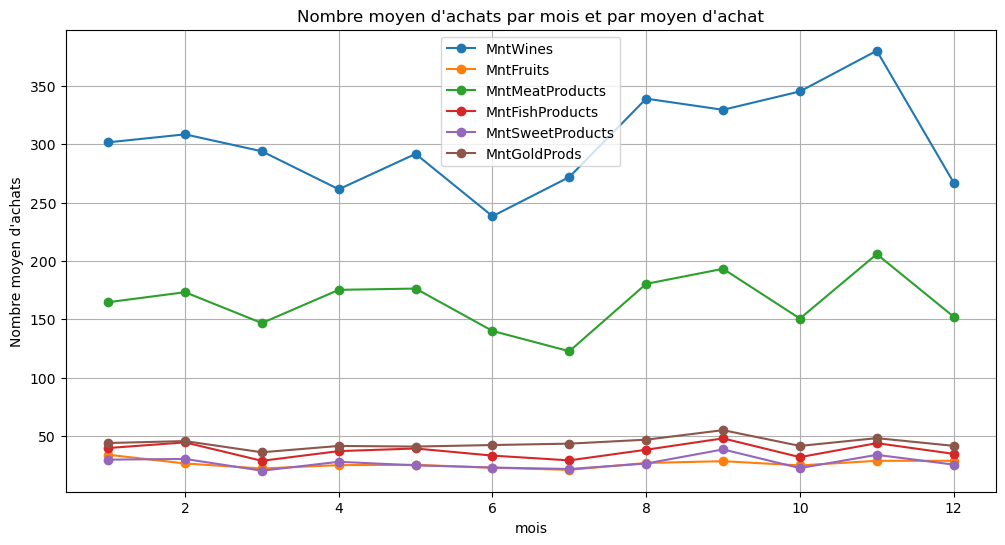

In [67]:
# Sélectionner les colonnes d'achat
typeachat = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds']
# Calculer la moyenne des achats par mois et par type d'achat
average_purchases_by_month = df_clean.groupby('month')[typeachat].mean()

# Afficher le résultat
print("Nombre moyen d'achats par an et par moyen d'achat :")
print(average_purchases_by_month)
# Tracer un graphique
average_purchases_by_month.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Nombre moyen d\'achats par mois et par moyen d\'achat')
plt.xlabel('mois')
plt.ylabel('Nombre moyen d\'achats')
plt.grid(True)
plt.show()

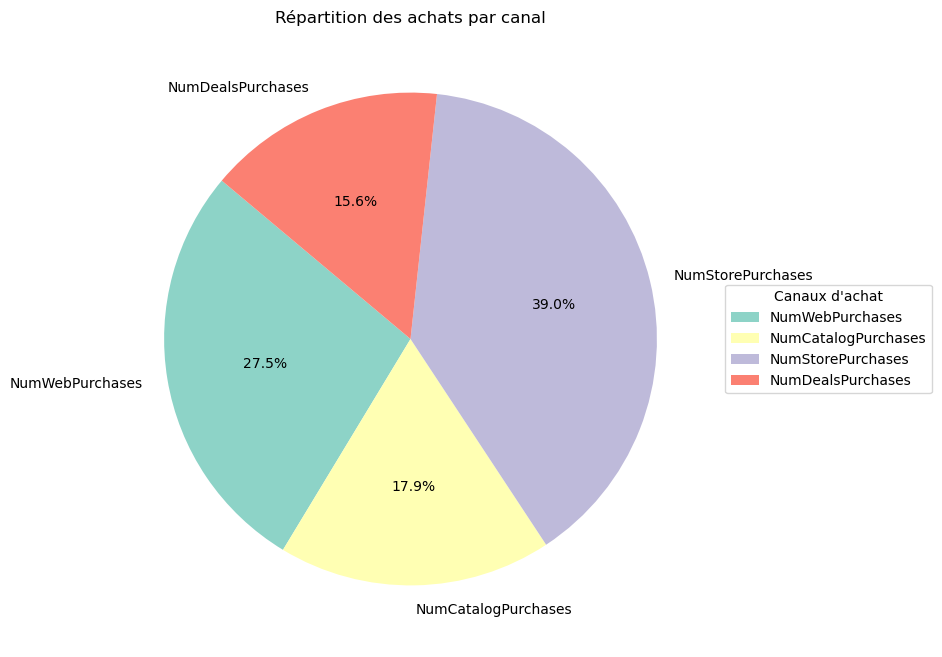

In [130]:
achat_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases']

# Calculer la somme totale des achats pour chaque canal
total_achats = df_clean[achat_cols].sum()

# Créer le pie chart avec une légende
plt.figure(figsize=(8, 8))
plt.pie(total_achats, labels=achat_cols, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title('Répartition des achats par canal')
plt.legend(achat_cols, title="Canaux d'achat", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

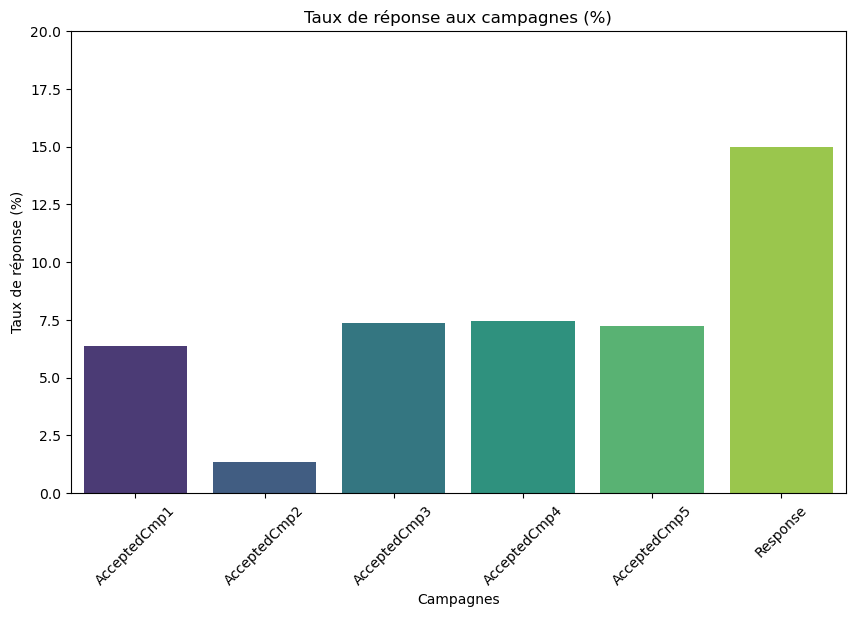

In [142]:
campagnes = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# Calculer le taux de réponse pour chaque campagne
taux_reponse = df_clean[campagnes].mean() * 100

# Créer un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=taux_reponse.index, y=taux_reponse.values, palette='viridis')
plt.title('Taux de réponse aux campagnes (%)')
plt.xlabel('Campagnes')
plt.ylabel('Taux de réponse (%)')
plt.ylim(0, 20)
plt.xticks(rotation=45)
plt.show()

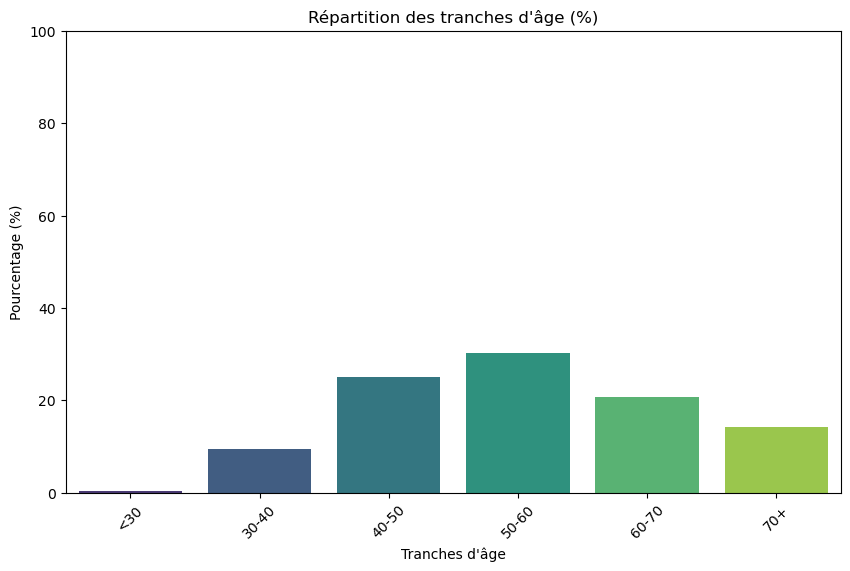

In [144]:
# Calculer la répartition des tranches d'âge
tranche_age_counts = df_clean['Age_Group'].value_counts(normalize=True) * 100

# Créer un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=tranche_age_counts.index, y=tranche_age_counts.values, palette='viridis')
plt.title('Répartition des tranches d\'âge (%)')
plt.xlabel('Tranches d\'âge')
plt.ylabel('Pourcentage (%)')
plt.ylim(0, 100)  # Échelle à 100%
plt.xticks(rotation=45)
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Étape 2.5 : Heatmap de corrélation</h2>
</div>

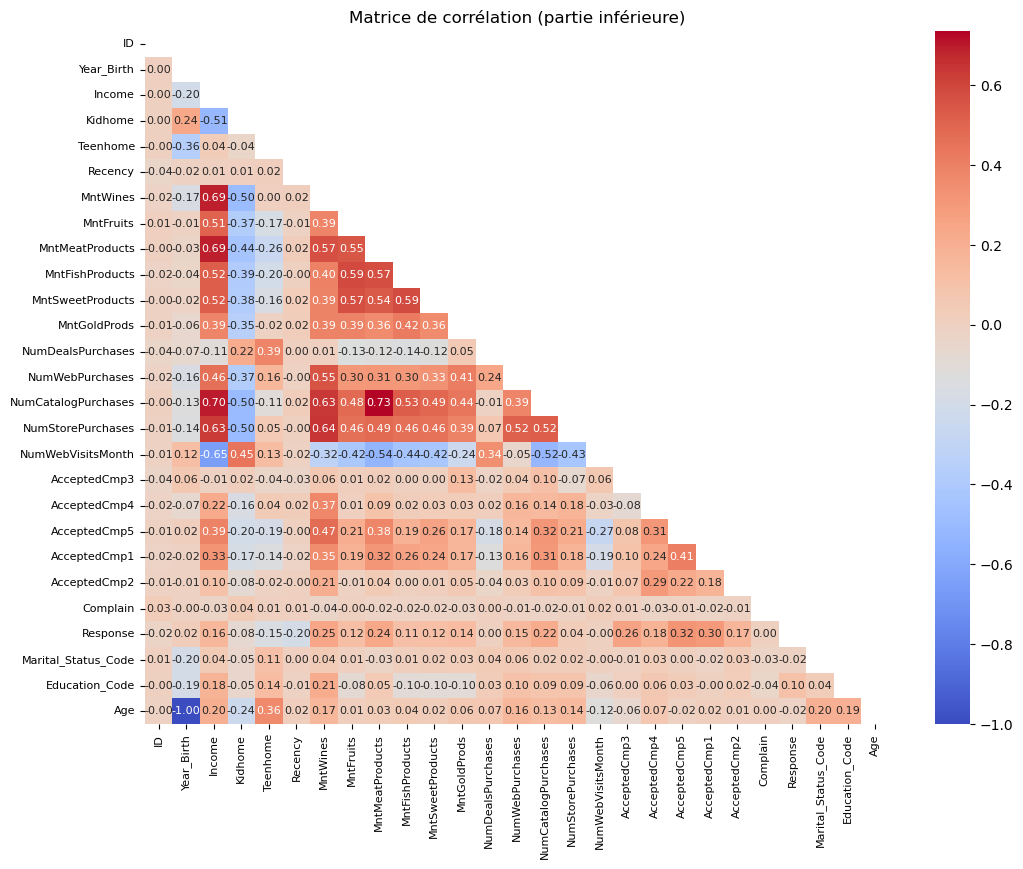

In [71]:
# Création heatmap
corr = df_clean.select_dtypes(include=['int64', 'float64']).corr()

# Masque pour la partie supérieure
mask = np.triu(np.ones_like(corr, dtype=bool))

# Affichage de la heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Matrice de corrélation (partie inférieure)", fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Étape 3 : Clustering avec Méthode du Coude</h2>
</div>

In [85]:
# Sélectionner les colonnes numériques
int_float_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Imputer les valeurs manquantes et standardiser les données
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(df_clean[int_float_columns])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

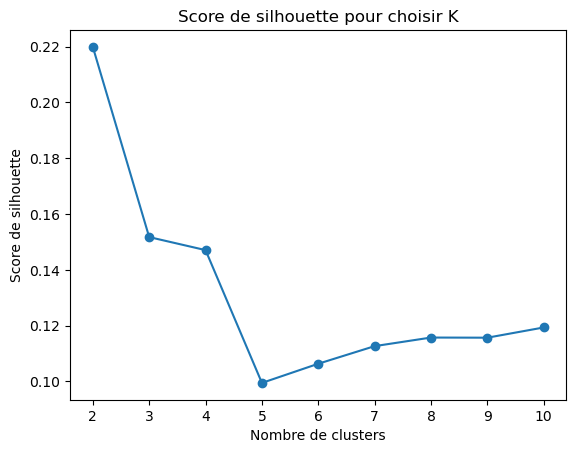

In [91]:
# Détermination du nombre optimal de clusters avec Score de silhouette
silhouette_scores = []
for k in range(2, 11):
	kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
	labels = kmeans.fit_predict(scaled_data)
	score = silhouette_score(scaled_data, labels)
	silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour choisir K')
plt.show()

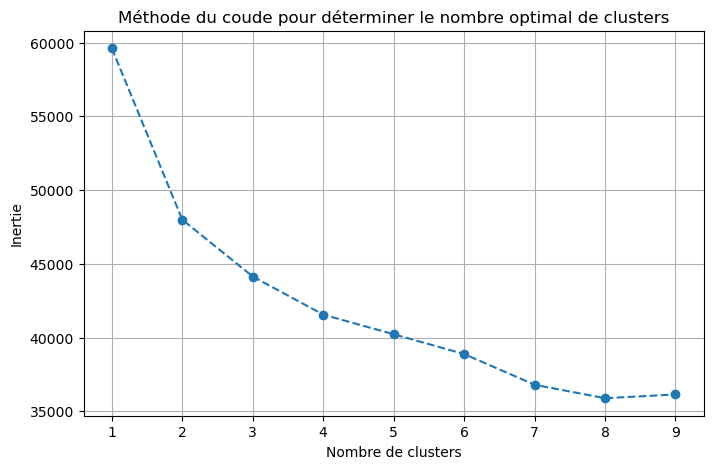

In [25]:
# Méthode du coude
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.xticks(range(1, 10))
plt.grid()
plt.show()

In [102]:
# Clustering K-means avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

df_clean['Cluster'] = clusters

# Sélectionner uniquement les colonnes numériques
numeric_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Tableau des médianes par cluster pour les colonnes numériques
median_by_cluster = df_clean[numeric_columns].groupby(df_clean['Cluster']).mean()
print("Médianes des variables numériques par cluster :")
median_by_cluster.head(5)

Médianes des variables numériques par cluster :


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Marital_Status_Code,Education_Code,Age
Cluster,,,,,,,,,,,,,,,,,,,,,
0,5513.648729,1962.509716,57915.790732,0.201794,0.935725,48.061286,435.318386,20.829596,127.729447,28.657698,...,0.011958,0.026906,0.013453,0.008969,3.0,11.0,0.106129,1.545590,3.742900,59.490284
1,5603.526477,1973.115071,33989.865580,0.831976,0.407332,49.338086,40.919552,5.591650,24.949084,7.875764,...,0.000000,0.001018,0.002037,0.012220,3.0,11.0,0.095723,1.260692,3.287169,48.884929
2,5636.183124,1969.161580,76422.947935,0.044883,0.163375,49.759425,614.955117,69.371634,464.621185,100.456014,...,0.272890,0.219031,0.034111,0.003591,3.0,11.0,0.298025,1.299820,3.421903,52.838420


In [29]:
# Nombre de pays par cluster
nb_cluster = df_clean.groupby(['Cluster'])['ID'].count()
nb_cluster

Cluster
0    974
1    680
2    554
Name: ID, dtype: int64

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Étape 4 : Visualisation en 2D avec PCA</h2>
</div>

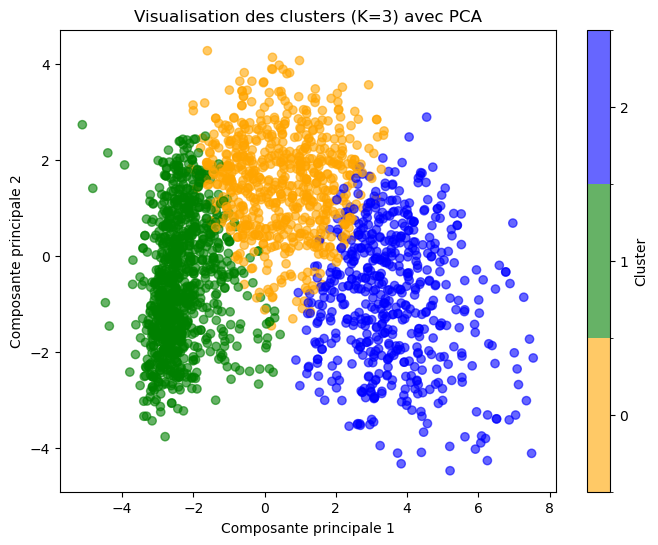

In [110]:
# Visualisation en 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))

# Palette de couleur
base_colors = ['orange', 'green', 'blue']
if n_clusters <= 3:
    colors_list = base_colors[:n_clusters]
else:
    colors_list = base_colors + ['gray'] * (n_clusters - 3)

cmap = ListedColormap(colors_list)
norm = BoundaryNorm(np.arange(-0.5, n_clusters + 0.5), n_clusters)

# Utilisation d'un nuage de point
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap=cmap, norm=norm, alpha=0.6)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title(f'Visualisation des clusters (K={n_clusters}) avec PCA')
cbar = plt.colorbar(sc, ticks=range(n_clusters))
cbar.set_label('Cluster')

# Afficher
plt.show()

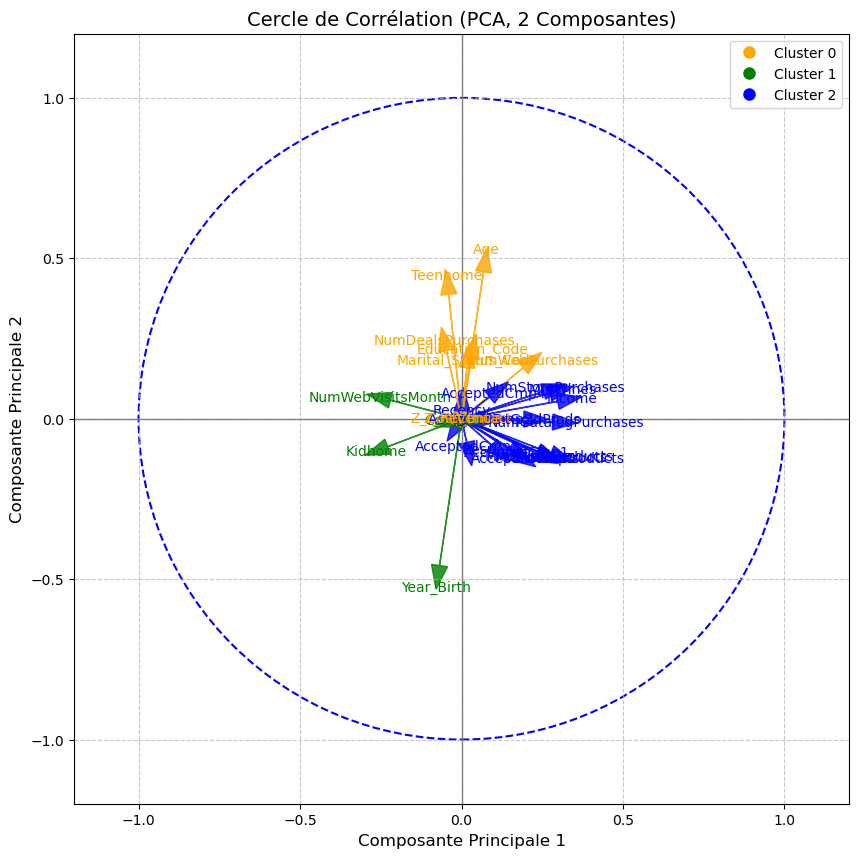

In [116]:
# Calcul des composantes principales
pcs = pca.components_

# Création du cercle
plt.figure(figsize=(10, 10))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1.5)
plt.gca().add_artist(circle)

# Calculer la moyenne des variables pour chaque cluster
cluster_means = pd.DataFrame(scaled_data, columns=int_float_columns)
cluster_means['Cluster'] = clusters
means = cluster_means.groupby('Cluster').mean()

# Affichage des vecteurs des variables
vector_color_map = {0: 'orange', 1: 'green', 2: 'blue'}

# Ajuster la longueur des flèches
scale_factor = 0.9

for i, col in enumerate(int_float_columns):
    try:
        dominant_cluster = int(means[col].idxmax())
    except Exception:
        dominant_cluster = None
    color = vector_color_map.get(dominant_cluster, 'gray')
    plt.arrow(0, 0, pcs[0, i] * scale_factor, pcs[1, i] * scale_factor, color=color, alpha=0.8, head_width=0.05)
    plt.text(pcs[0, i] * scale_factor * 1.15, pcs[1, i] * scale_factor * 1.15, col, fontsize=10, color=color, ha='center', va='center')

# Ajouter une légende pour les couleurs des clusters
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', markerfacecolor=color, markersize=10)
                   for i, color in vector_color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Composante Principale 1', fontsize=12)
plt.ylabel('Composante Principale 2', fontsize=12)
plt.title('Cercle de Corrélation (PCA, 2 Composantes)', fontsize=14)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.grid(linestyle='--', alpha=0.7)

# afficher
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Étape 5 : Analyse des clusters</h2>
</div>

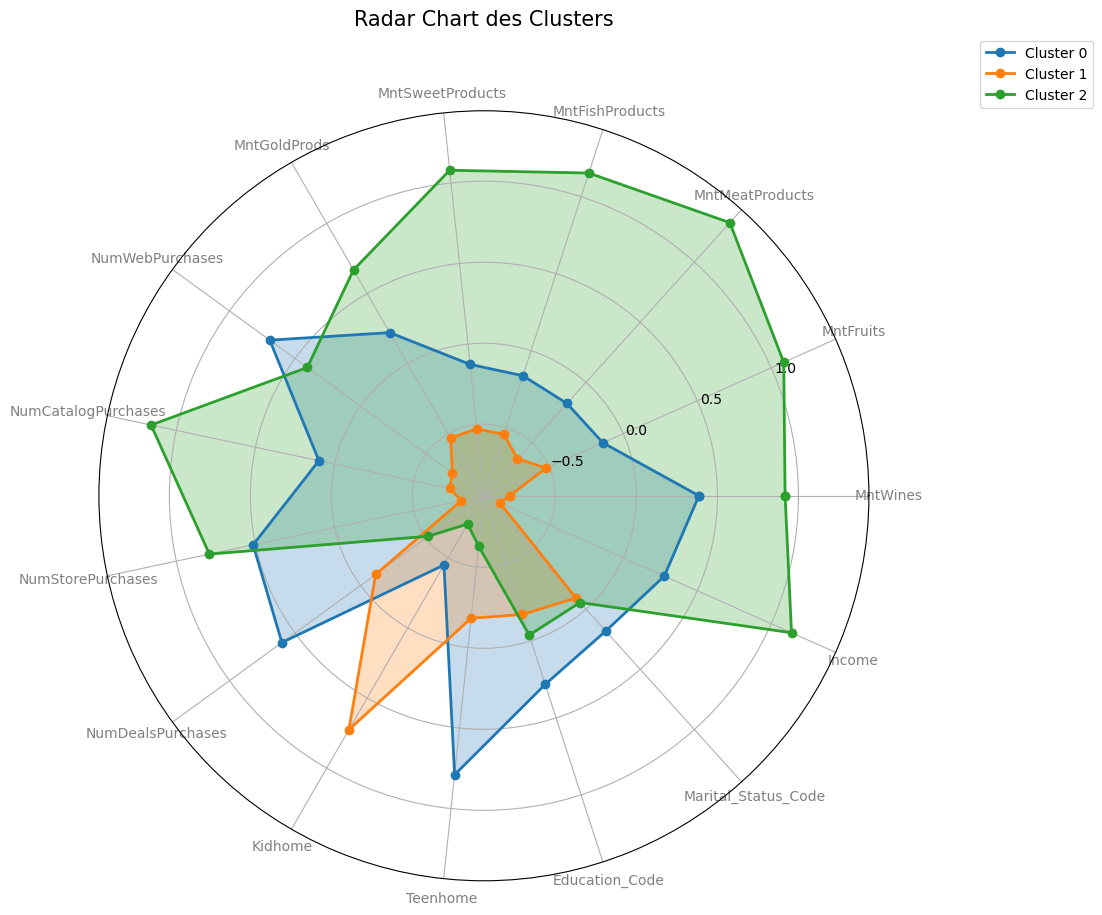

In [120]:
# Selection des features (toutes)
feature = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'Kidhome', 'Teenhome', 'Education_Code', 'Marital_Status_Code', 'Income'
]

# Normalisation des données
scaler_radar = StandardScaler()
scaled_features_radar = scaler_radar.fit_transform(df_clean[feature])

# Utilisation d'un graphique radar  par cluster
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

angles = np.linspace(0, 2 * np.pi, len(feature), endpoint=False).tolist()
angles += angles[:1]

# Dessiner un axe par variable + ajouter des étiquettes
plt.xticks(angles[:-1], feature, color='grey', size=10)

# Data pour les clusters
for cluster in range(3):
    cluster_data = scaled_features_radar[df_clean['Cluster'] == cluster]
    mean_values = np.mean(cluster_data, axis=0)
    mean_values = np.concatenate((mean_values, [mean_values[0]]))
    ax.plot(angles, mean_values, 'o-', linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, mean_values, alpha=0.25)

# # Ajouter une légende
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Titre et affichage
plt.title('Radar Chart des Clusters', size=15, y=1.1)

plt.show()

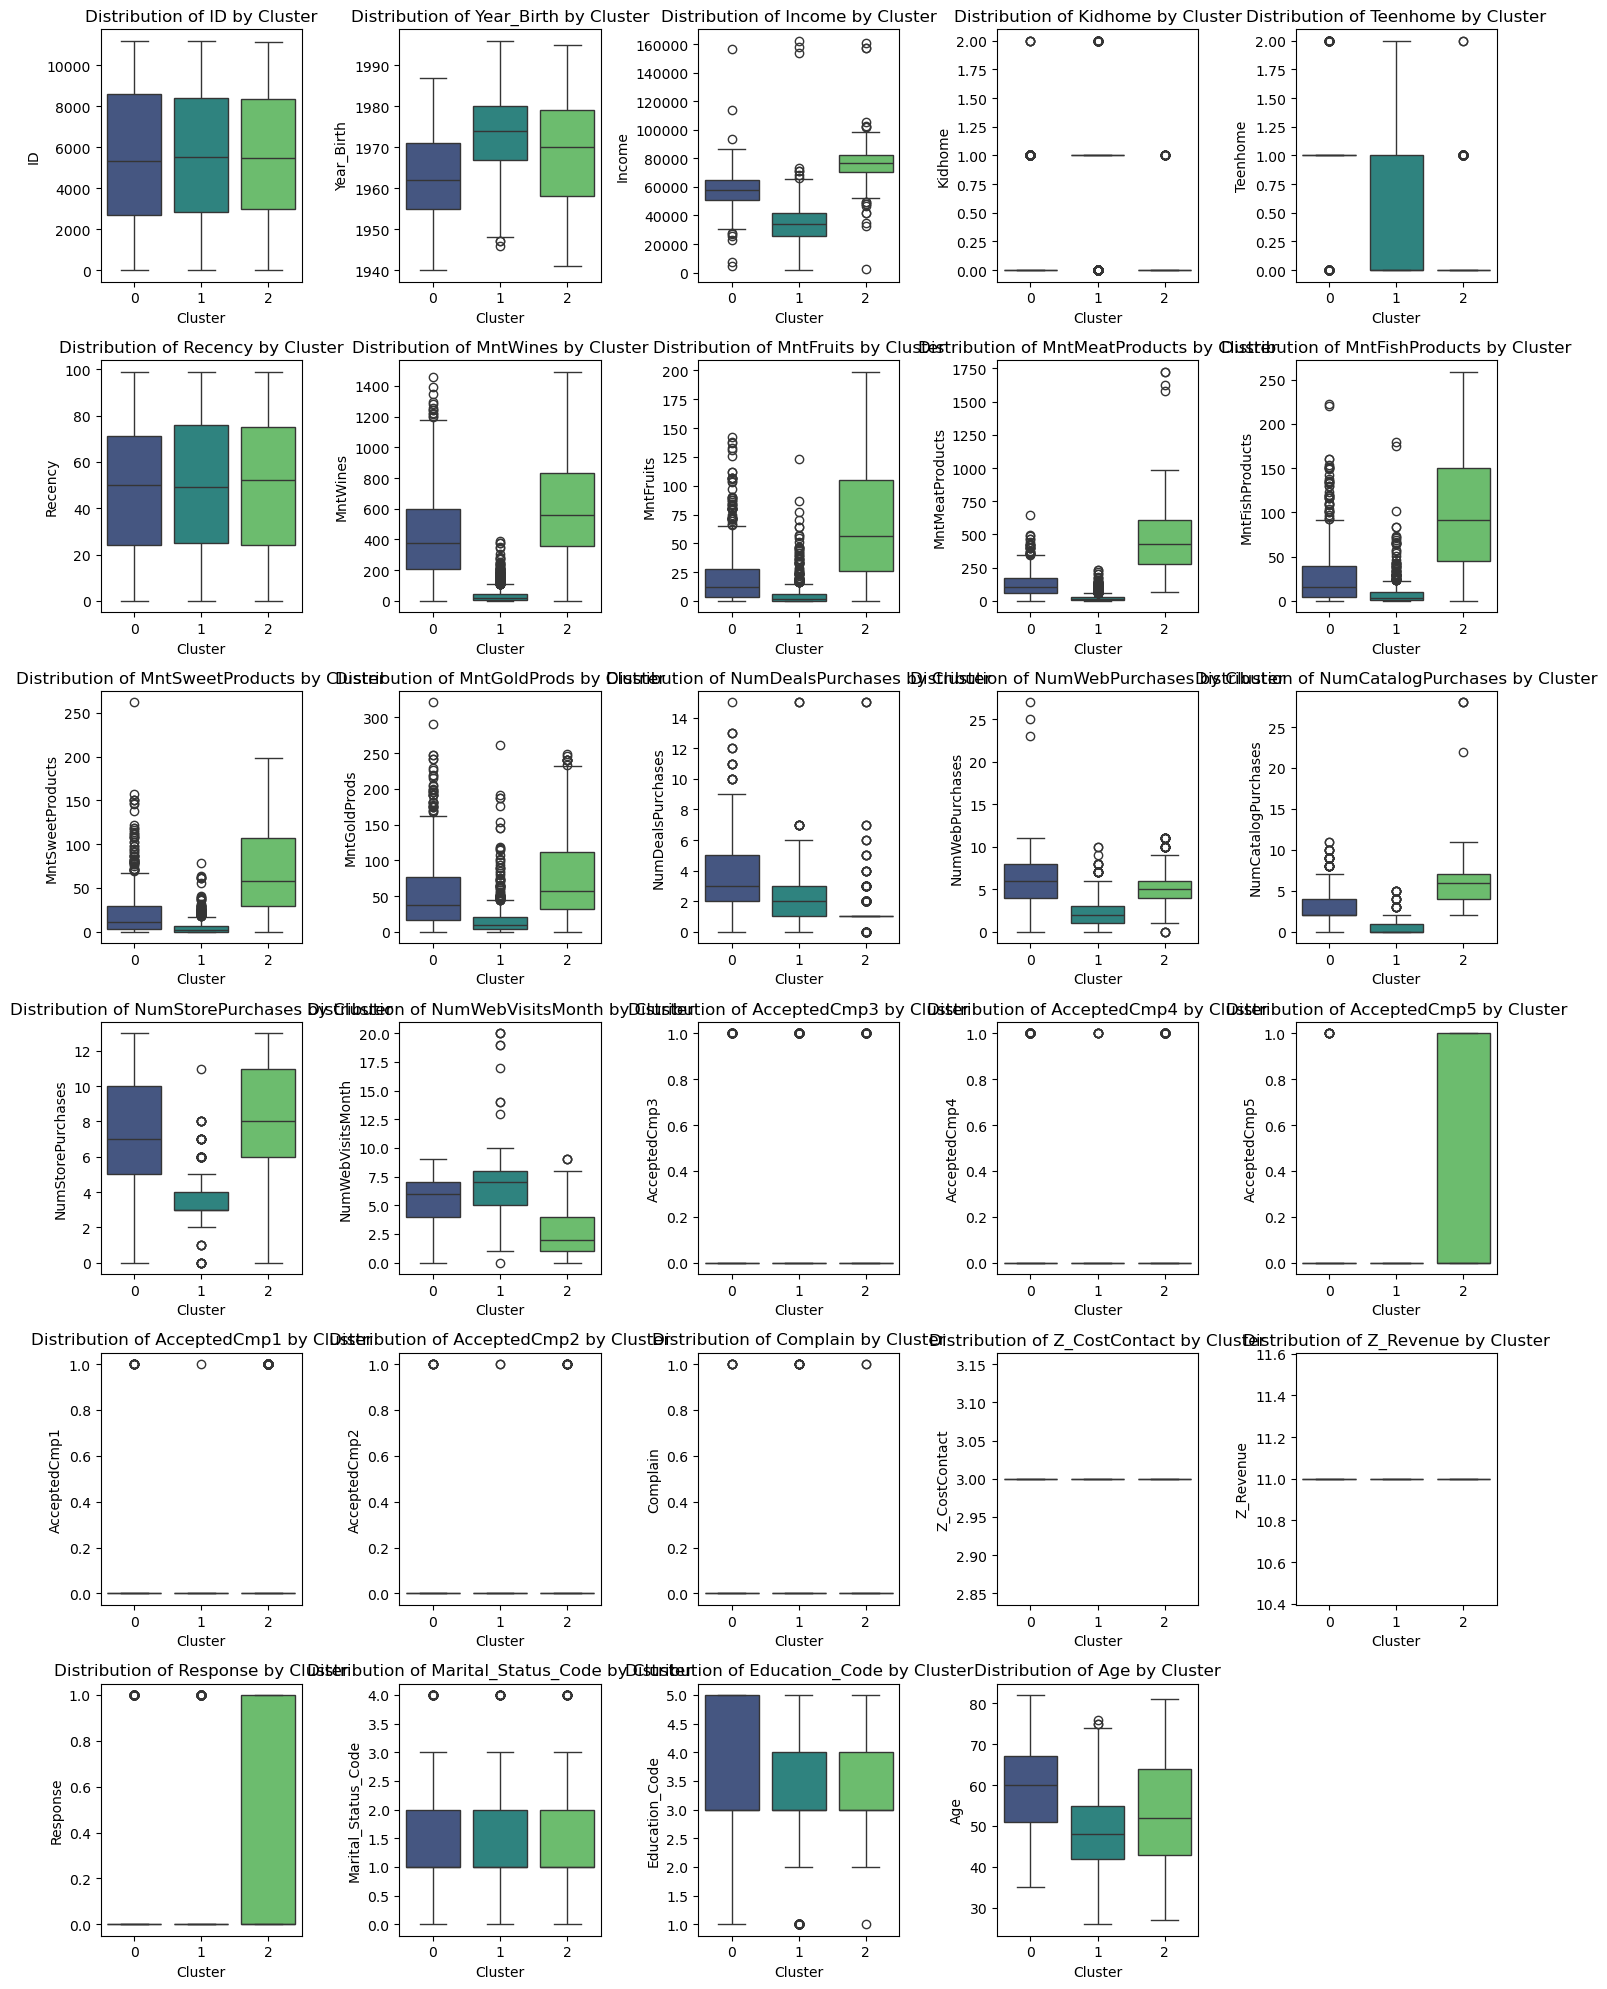

In [122]:
# Boxplots pour toutes les variables par cluster
plt.figure(figsize=(15, 20))
for i, feature in enumerate(int_float_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(x='Cluster', y=feature, data=df_clean, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster')
plt.tight_layout()
plt.show()

         AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
Cluster                                                                         
0                2.69          1.35          6.13         12.71          1.20   
1                0.10          0.20          7.64          0.61          0.00   
2               21.90          3.41          8.44         13.11         27.29   

         Response  
Cluster            
0           10.61  
1            9.57  
2           29.80  


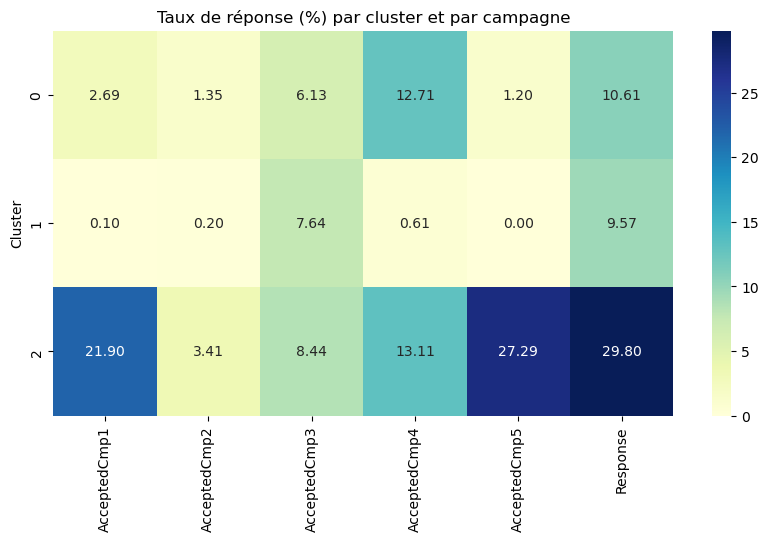

In [124]:
# Colonnes des campagnes
campagnes = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# Calculer le taux de réponse par cluster
taux_par_cluster = df_clean.groupby('Cluster')[campagnes].mean() * 100

# Afficher le résultat arrondi à 2 décimales
taux_par_cluster = taux_par_cluster.round(2)
print(taux_par_cluster)

# Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(taux_par_cluster, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Taux de réponse (%) par cluster et par campagne")
plt.show()

         NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
Cluster                                                            
0                    6.0                  2.0                7.0   
1                    2.0                  0.0                3.0   
2                    5.0                  6.0                8.0   

         NumDealsPurchases  
Cluster                     
0                      3.0  
1                      2.0  
2                      1.0  


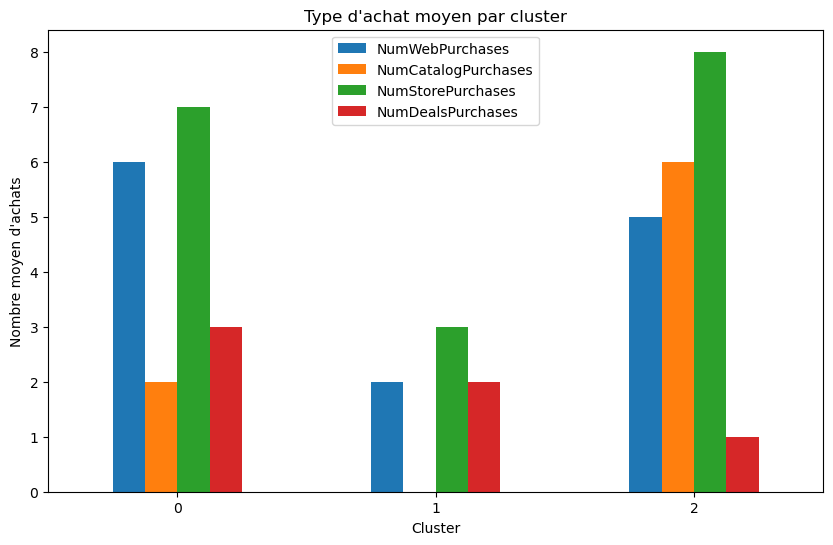

In [126]:
# Colonnes pour les types d'achat
achat_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases']

# Moyenne par cluster
achat_par_cluster = df_clean.groupby('Cluster')[achat_cols].median().round(2)
print(achat_par_cluster)

# Visualisation avec un barplot par type d'achat
achat_par_cluster.plot(kind='bar', figsize=(10,6))
plt.title("Type d'achat moyen par cluster")
plt.ylabel("Nombre moyen d'achats")
plt.xlabel("Cluster")
plt.xticks(rotation=0)

#Afficher
plt.show()

         MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Cluster                                                          
0           40.64       5.56            24.89             7.82   
1          430.07      20.72           127.37            28.54   
2          617.17      69.60           465.51           100.78   

         MntSweetProducts  MntGoldProds  
Cluster                                  
0                    5.41         16.33  
1                   21.74         55.19  
2                   71.68         78.05  


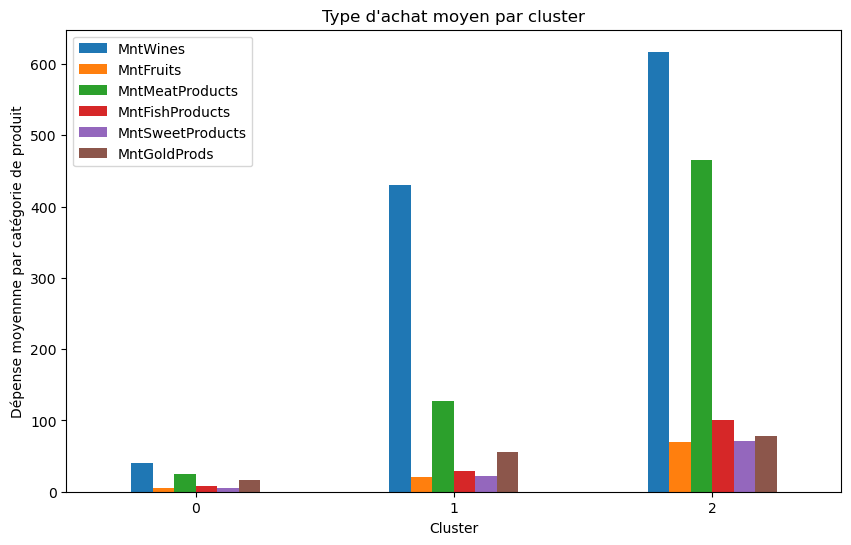

In [51]:
# Colonnes pour les types d'achat
typeachat = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds']

# Moyenne par cluster
type_achat_par_cluster = df_clean.groupby('Cluster')[typeachat].mean().round(2)
print(type_achat_par_cluster)

# Visualisation avec un barplot par type d'achat
type_achat_par_cluster.plot(kind='bar', figsize=(10,6))
plt.title("Type d'achat moyen par cluster")
plt.ylabel("Dépense moyennne par catégorie de produit")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()

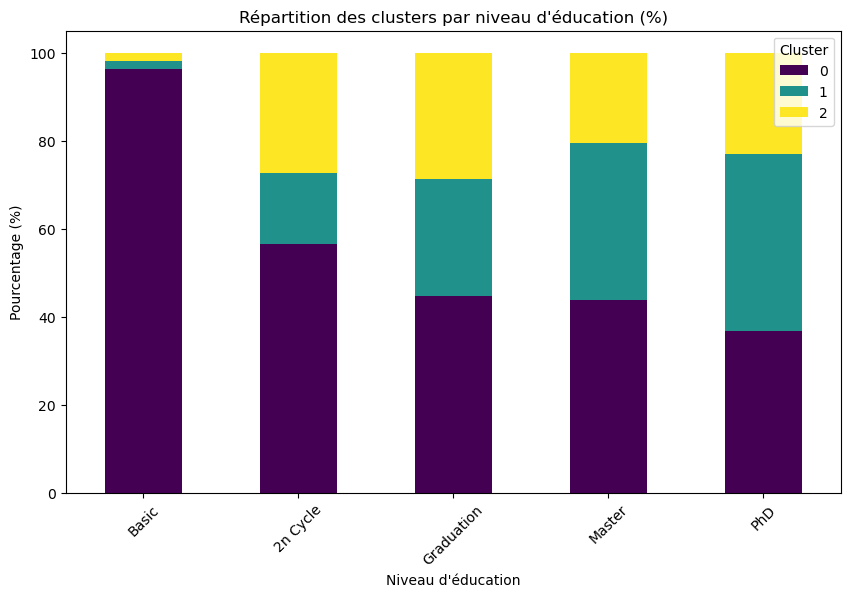

In [292]:
# Mapper les codes numériques aux labels
education_labels = {1: 'Basic', 2: '2n Cycle', 3: 'Graduation', 4: 'Master', 5: 'PhD'}
df_clean['Education_Label'] = df_clean['Education_Code'].map(education_labels)

# Créer un DataFrame pour la répartition des clusters par niveau d'éducation
education_cluster_distribution = pd.crosstab(index=df_clean['Education_Code'],
                                             columns=df_clean['Cluster'],
                                             normalize='index') * 100

# Ajouter les labels pour l'axe des x
education_cluster_distribution.index = education_cluster_distribution.index.map(education_labels)

# Tracer le barplot empilé
education_cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Répartition des clusters par niveau d\'éducation (%)')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Pourcentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


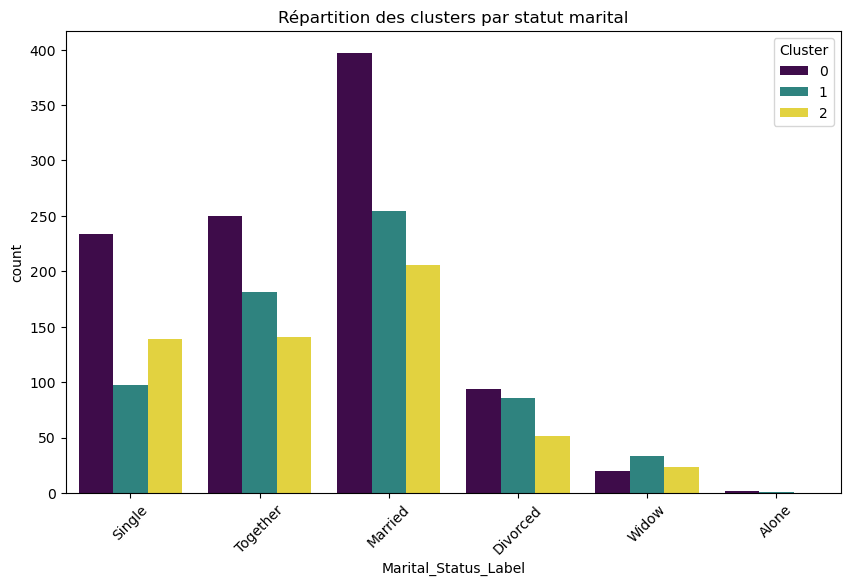

In [294]:
# Mapper les codes numériques aux labels
marital_labels = {
    0: 'Single', 1: 'Married', 2: 'Together', 3: 'Divorced',
    4: 'Widow', 5: 'Alone', 6: 'Absurd', 7: 'YOLO'
}
df_clean['Marital_Status_Label'] = df_clean['Marital_Status_Code'].map(marital_labels)

# Créer un barplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Marital_Status_Label', hue='Cluster', palette='viridis')
plt.title('Répartition des clusters par statut marital')
plt.xticks(rotation=45)
plt.show()

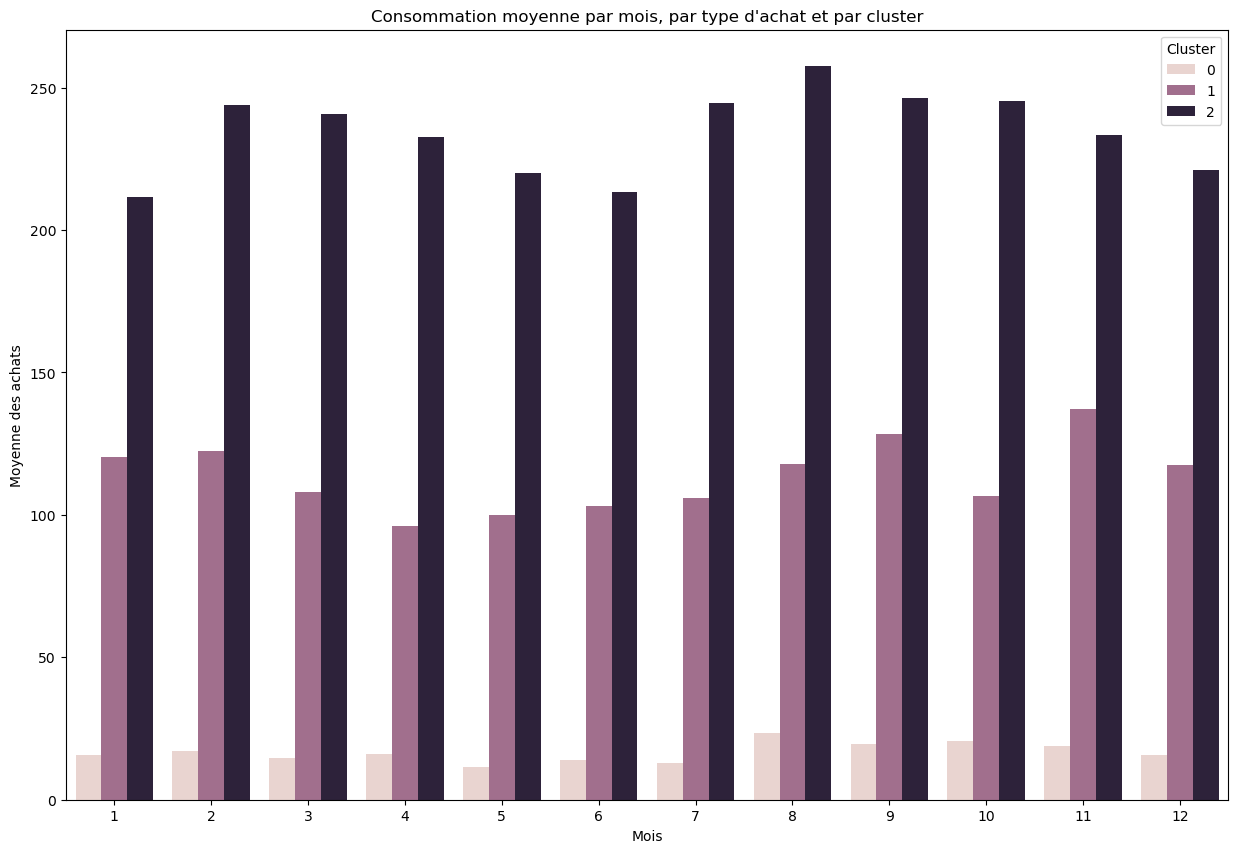

In [59]:
# Calculer la moyenne des achats par mois, par type d'achat et par cluster
average_purchases_by_month_cluster = df_clean.groupby(['month', 'Cluster'])[typeachat].mean()

# Réorganiser les données pour une meilleure visualisation
average_purchases_by_month_cluster = average_purchases_by_month_cluster.stack().reset_index()
average_purchases_by_month_cluster.columns = ['month', 'Cluster', 'typeachat', 'Moyenne_Achat']

plt.figure(figsize=(15, 10))
sns.barplot(data=average_purchases_by_month_cluster,
            x='month',
            y='Moyenne_Achat',
            hue='Cluster',
            ci=None)
plt.title('Consommation moyenne par mois, par type d\'achat et par cluster')
plt.xlabel('Mois')
plt.ylabel('Moyenne des achats')
plt.show()